In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("stealthtechnologies/sci-fi-short-stories")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/


In [2]:
!pip install cleantext

In [88]:
import pandas as pd
import numpy as np
import os
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns
import cleantext
from collections import Counter
import spacy
from heapq import nlargest
from transformers import BartTokenizer, BartForConditionalGeneration, T5Tokenizer, T5ForConditionalGeneration, AutoTokenizer, AutoModelForCausalLM
from transformers import PegasusTokenizer, PegasusForConditionalGeneration
sns.set()

In [5]:
os.listdir('/kaggle/input/')

['stories.csv']

In [6]:
df = pd.read_csv('/kaggle/input/stories.csv', on_bad_lines = 'skip')
df.head()

,id,title,story
0,1,The Last Starship,"In the year 3050, humanity’s last starship, *E..."
1,2,The Time Weaver,"Dr. Elara Voss, a brilliant physicist, had jus..."
2,3,Echoes of Andromeda,Astronomer Dr. Ravi Patel was thrilled when he...
3,4,The Quantum Librarian,"In the year 2200, the Quantum Library was the ..."
4,5,The Celestial Voyager,Captain Marcus Steele commanded the *Celestial...


In [7]:
df.shape

(19, 3)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19 non-null     int64 
 1   title   19 non-null     object
 2   story   19 non-null     object
dtypes: int64(1), object(2)
memory usage: 588.0+ bytes


In [9]:
df.apply(pd.isnull).sum()

id       0
title    0
story    0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
df['story'][0]

'In the year 3050, humanity’s last starship, *Endeavour*, sailed through the dark void of space. The once bustling Earth was now a distant memory, consumed by environmental collapse. The crew, led by Captain Aria Nelson, was on a mission to find a new home. One day, as the ship scanned distant star systems, an ancient alien signal emerged from a forgotten corner of the galaxy. The signal, a cryptic message, hinted at a star system with planets capable of supporting life. Excitement filled the crew as they set course for the coordinates. Upon arrival, they discovered a solar system with three habitable planets. The crew began detailed scans and found an ancient archive buried beneath the surface of the third planet. The archive contained records of a civilization that had mastered space travel but chose to leave the system millennia ago. As the crew decoded the messages, they learned that the alien race had left behind advanced terraforming technology and detailed instructions for creat

In [12]:
df['story'][1]

'Dr. Elara Voss, a brilliant physicist, had just completed her greatest invention: the Temporal Manipulator. This machine could alter time on a minuscule scale, affecting events within a small temporal window. Elara was excited to test her invention, eager to see its potential. During her first experiment, she made a minor adjustment to a single event. To her dismay, the results were far from what she expected. The minor change caused significant ripples, creating inconsistencies in the timeline. Historical records began to shift, and reality itself started to unravel. Elara realized that her experiment had inadvertently created a paradox. Desperate to fix the timeline, she sought the help of her assistant, Tom. Together, they analyzed the anomalies and discovered a more troubling issue: an alternate version of Elara from a different timeline was also trying to correct the paradox. Meeting her alternate self was both enlightening and disconcerting. The two Elaras had different approach

In [13]:
df['story'][2]

'Astronomer Dr. Ravi Patel was thrilled when he detected a signal from the Andromeda galaxy. The signal, a complex pattern of electromagnetic waves, indicated the presence of an intelligent alien species. The news spread quickly, and a mission was organized to establish contact. Dr. Patel and his team traveled across the vast expanse of space in their starship, *Aurora*. When they arrived at the source of the signal, they discovered a planet with an advanced civilization. The aliens communicated through musical patterns, creating an intricate symphony that conveyed information. The team faced the challenge of understanding the alien language, which was entirely different from any form of communication they had encountered. With the help of advanced translation technology and a musical expert on board, they gradually deciphered the messages. The aliens revealed that they had been listening to Earth’s broadcasts for centuries, learning about human culture. They expressed a desire to esta

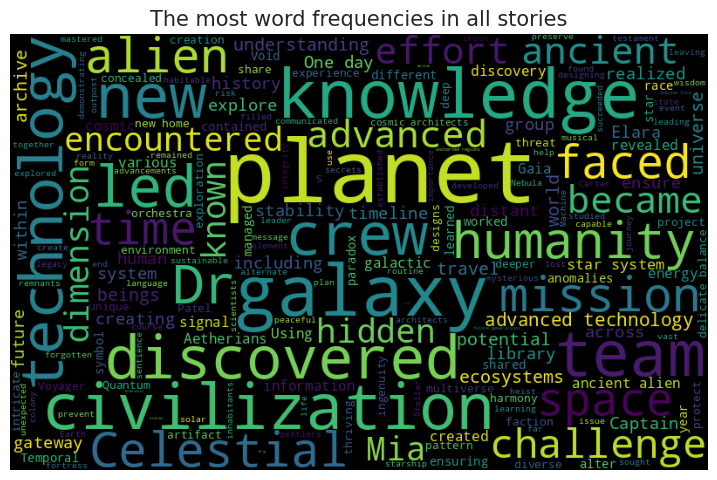

In [14]:
plt.figure(figsize = (9, 7))
all_sents = ' '.join([sentence for sentence in df['story']])
word_cloud = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sents)
plt.imshow(word_cloud)
plt.title('The most word frequencies in all stories', fontsize = 15)
plt.axis('off')
plt.show()

In [15]:
def cleaning_text(text):
    return cleantext.clean_words(
        text,
        clean_all = False,
        extra_spaces = True,
        stemming = False,
        stopwords = True,
        lowercase = True,
        numbers = True, 
        punct = True,
        stp_lang = 'english'
    )

In [16]:
def word_freq(words):
    return Counter(words)

In [17]:
def scaling_freq(freq_dict):
    scaled_dict = dict()
    max_freq = max(freq_dict.values())
    for word, freq in freq_dict.items():
        scaled_dict[word] = freq / max_freq
    return scaled_dict

In [18]:
def word_frequencies(text):
    words = cleaning_text(text)
    word_freqent = word_freq(words)
    word_fr_sc = scaling_freq(word_freqent)
    return word_fr_sc

In [19]:
def sentence_freq(text):
    word_fr_sc = word_frequencies(text)
    sents_freq = dict()
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)
    all_sentences = [sentence.text for sentence in doc.sents]
    for sentence in all_sentences:
        for word in sentence.split():
            if word in word_fr_sc.keys():
                if sentence not in sents_freq.keys():
                    sents_freq[sentence] = word_fr_sc[word]
                else:
                    sents_freq[sentence] += word_fr_sc[word]
    return sents_freq, all_sentences

In [20]:
def ex_summ(text, num_sentences):
    ordered_sents = []
    sents_freq, all_sentences = sentence_freq(text)
    sents = nlargest(num_sentences, sents_freq, key = sents_freq.get)
    for i in all_sentences:
        for j in sents:
            if i == j:
                ordered_sents.append(i)
    return ' '.join(ordered_sents)

In [21]:
df['ex_summ'] = df['story'].apply(lambda x: ex_summ(x, 3))

In [22]:
df.head()

,id,title,story,ex_summ
0,1,The Last Starship,"In the year 3050, humanity’s last starship, *E...",The crew began detailed scans and found an anc...
1,2,The Time Weaver,"Dr. Elara Voss, a brilliant physicist, had jus...",This machine could alter time on a minuscule s...
2,3,Echoes of Andromeda,Astronomer Dr. Ravi Patel was thrilled when he...,The team faced the challenge of understanding ...
3,4,The Quantum Librarian,"In the year 2200, the Quantum Library was the ...",Curiosity led her to a concealed section conta...
4,5,The Celestial Voyager,Captain Marcus Steele commanded the *Celestial...,On a routine mission to chart uncharted region...


In [23]:
df['story'][0]

'In the year 3050, humanity’s last starship, *Endeavour*, sailed through the dark void of space. The once bustling Earth was now a distant memory, consumed by environmental collapse. The crew, led by Captain Aria Nelson, was on a mission to find a new home. One day, as the ship scanned distant star systems, an ancient alien signal emerged from a forgotten corner of the galaxy. The signal, a cryptic message, hinted at a star system with planets capable of supporting life. Excitement filled the crew as they set course for the coordinates. Upon arrival, they discovered a solar system with three habitable planets. The crew began detailed scans and found an ancient archive buried beneath the surface of the third planet. The archive contained records of a civilization that had mastered space travel but chose to leave the system millennia ago. As the crew decoded the messages, they learned that the alien race had left behind advanced terraforming technology and detailed instructions for creat

In [24]:
df['ex_summ'][0]

'The crew began detailed scans and found an ancient archive buried beneath the surface of the third planet. As the crew decoded the messages, they learned that the alien race had left behind advanced terraforming technology and detailed instructions for creating a new home. The crew worked tirelessly to implement the alien technology, making the planets habitable and ensuring they were ready for the cataclysm.'

In [25]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

In [26]:
bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [27]:
def ab_summ(text):
    tokenized_text = tokenizer(text, max_length = 1024, truncation = True, return_tensors = 'pt')
    summ_text = bart_model.generate(tokenized_text['input_ids'], min_length = 150, max_length = 400, num_beams = 4, length_penalty = 2.0, early_stopping = True)
    return tokenizer.decode(summ_text[0], skip_special_tokens = True)

In [28]:
ab_summ(df['story'][0])

'In 3050, humanity’s last starship, *Endeavour*, sailed through the dark void of space. The crew, led by Captain Aria Nelson, was on a mission to find a new home. One day, as the ship scanned distant star systems, an ancient alien signal emerged from a forgotten corner of the galaxy. The signal hinted at a star system with planets capable of supporting life. Upon arrival, they discovered a solar system with three habitable planets. The archive contained records of a civilization that had mastered space travel but chose to leave the system millennia ago. As the crew decoded the messages, they learned that the alien race had left behind advanced terraforming technology. However, they also discovered a warning: a catastrophic event had forced the aliens to abandon their home.'

In [29]:
df['story'][0]

'In the year 3050, humanity’s last starship, *Endeavour*, sailed through the dark void of space. The once bustling Earth was now a distant memory, consumed by environmental collapse. The crew, led by Captain Aria Nelson, was on a mission to find a new home. One day, as the ship scanned distant star systems, an ancient alien signal emerged from a forgotten corner of the galaxy. The signal, a cryptic message, hinted at a star system with planets capable of supporting life. Excitement filled the crew as they set course for the coordinates. Upon arrival, they discovered a solar system with three habitable planets. The crew began detailed scans and found an ancient archive buried beneath the surface of the third planet. The archive contained records of a civilization that had mastered space travel but chose to leave the system millennia ago. As the crew decoded the messages, they learned that the alien race had left behind advanced terraforming technology and detailed instructions for creat

In [30]:
ab_summ(df['story'][1])

'Dr. Elara Voss had just completed her greatest invention: the Temporal Manipulator. The machine could alter time on a minuscule scale, affecting events within a small temporal window. During her first experiment, she made a minor adjustment to a single event. The minor change caused significant ripples, creating inconsistencies in the timeline. An alternate version of Elara from a different timeline was also trying to correct the paradox. The two Elaras had different approaches to resolving the timeline but shared a common goal. They combined their knowledge and skills, working together to stabilize the temporal distortions. After intense effort, they managed to restore the timeline to its original state. The Tem temporal Manipulator was shut down, and its technology was secured to prevent further misuse.'

In [31]:
df['story'][1]

'Dr. Elara Voss, a brilliant physicist, had just completed her greatest invention: the Temporal Manipulator. This machine could alter time on a minuscule scale, affecting events within a small temporal window. Elara was excited to test her invention, eager to see its potential. During her first experiment, she made a minor adjustment to a single event. To her dismay, the results were far from what she expected. The minor change caused significant ripples, creating inconsistencies in the timeline. Historical records began to shift, and reality itself started to unravel. Elara realized that her experiment had inadvertently created a paradox. Desperate to fix the timeline, she sought the help of her assistant, Tom. Together, they analyzed the anomalies and discovered a more troubling issue: an alternate version of Elara from a different timeline was also trying to correct the paradox. Meeting her alternate self was both enlightening and disconcerting. The two Elaras had different approach

In [32]:
tokenizer2 = T5Tokenizer.from_pretrained('google-t5/t5-small')

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [33]:
t5_model = T5ForConditionalGeneration.from_pretrained('google-t5/t5-small')

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [34]:
def ab_summ_t5(text):
    tokenized_text = tokenizer2(text, max_length = 1024, return_tensors = 'pt')
    summ_text = t5_model.generate(tokenized_text['input_ids'], min_length = 150, max_length = 400, length_penalty = 2.0, num_beams = 4, early_stopping = True)
    return tokenizer2.decode(summ_text[0], skip_special_tokens = True)

In [36]:
ab_summ_t5(df['story'][0])

"sailed through the dark void of space in the year 3050. The crew, led by Captain Aria Nelson, was on a mission to find a new home. Upon arrival, they discovered a solar system with three habitable planets. the crew began detailed scans and found an ancient archive buried beneath the surface of the third planet. the archive contained records of a civilization that had mastered space travel but chose to leave the system millennia ago. Upon arrival,......................................................................... 'Endeavour*......"

In [37]:
df['story'][0]

'In the year 3050, humanity’s last starship, *Endeavour*, sailed through the dark void of space. The once bustling Earth was now a distant memory, consumed by environmental collapse. The crew, led by Captain Aria Nelson, was on a mission to find a new home. One day, as the ship scanned distant star systems, an ancient alien signal emerged from a forgotten corner of the galaxy. The signal, a cryptic message, hinted at a star system with planets capable of supporting life. Excitement filled the crew as they set course for the coordinates. Upon arrival, they discovered a solar system with three habitable planets. The crew began detailed scans and found an ancient archive buried beneath the surface of the third planet. The archive contained records of a civilization that had mastered space travel but chose to leave the system millennia ago. As the crew decoded the messages, they learned that the alien race had left behind advanced terraforming technology and detailed instructions for creat

In [39]:
tokenizer3 = AutoTokenizer.from_pretrained('gavin124/gpt2-finetuned-cnn-summarization-v1')

tokenizer_config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/999k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/75.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [41]:
gpt2_model = AutoModelForCausalLM.from_pretrained('gavin124/gpt2-finetuned-cnn-summarization-v1')

config.json:   0%|          | 0.00/907 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/510M [00:00<?, ?B/s]

In [82]:
def gpt2_summ(text):
    tokenized_text = tokenizer3(text, max_length = 1024, truncation = True, return_tensors = 'pt')
    tokenized_text['attention_mask'] = tokenized_text.get('attention_mask', None)
    pad_token_id = tokenizer3.eos_token_id
    summ_text = gpt2_model.generate(tokenized_text['input_ids'], attention_mask = tokenized_text['attention_mask'],
                                   min_length = 150, max_length = 400, num_beams = 10, length_penalty = 4.0,
                                   early_stopping = True, pad_token_id = pad_token_id)
    return tokenizer3.decode(summ_text[0], skip_special_tokens = True)

In [83]:
gpt2_summ(df['story'][0])

'In the year 3050, humanity’s last starship, *Endeavour*, sailed through the dark void of space. The once bustling Earth was now a distant memory, consumed by environmental collapse. The crew, led by Captain Aria Nelson, was on a mission to find a new home. One day, as the ship scanned distant star systems, an ancient alien signal emerged from a forgotten corner of the galaxy. The signal, a cryptic message, hinted at a star system with planets capable of supporting life. Excitement filled the crew as they set course for the coordinates. Upon arrival, they discovered a solar system with three habitable planets. The crew began detailed scans and found an ancient archive buried beneath the surface of the third planet. The archive contained records of a civilization that had mastered space travel but chose to leave the system millennia ago. As the crew decoded the messages, they learned that the alien race had left behind advanced terraforming technology and detailed instructions for creat

In [84]:
df['story'][0]

'In the year 3050, humanity’s last starship, *Endeavour*, sailed through the dark void of space. The once bustling Earth was now a distant memory, consumed by environmental collapse. The crew, led by Captain Aria Nelson, was on a mission to find a new home. One day, as the ship scanned distant star systems, an ancient alien signal emerged from a forgotten corner of the galaxy. The signal, a cryptic message, hinted at a star system with planets capable of supporting life. Excitement filled the crew as they set course for the coordinates. Upon arrival, they discovered a solar system with three habitable planets. The crew began detailed scans and found an ancient archive buried beneath the surface of the third planet. The archive contained records of a civilization that had mastered space travel but chose to leave the system millennia ago. As the crew decoded the messages, they learned that the alien race had left behind advanced terraforming technology and detailed instructions for creat

In [85]:
gpt2_summ(df['story'][1])

'Dr. Elara Voss, a brilliant physicist, had just completed her greatest invention: the Temporal Manipulator. This machine could alter time on a minuscule scale, affecting events within a small temporal window. Elara was excited to test her invention, eager to see its potential. During her first experiment, she made a minor adjustment to a single event. To her dismay, the results were far from what she expected. The minor change caused significant ripples, creating inconsistencies in the timeline. Historical records began to shift, and reality itself started to unravel. Elara realized that her experiment had inadvertently created a paradox. Desperate to fix the timeline, she sought the help of her assistant, Tom. Together, they analyzed the anomalies and discovered a more troubling issue: an alternate version of Elara from a different timeline was also trying to correct the paradox. Meeting her alternate self was both enlightening and disconcerting. The two Elaras had different approach

In [86]:
df['story'][1]

'Dr. Elara Voss, a brilliant physicist, had just completed her greatest invention: the Temporal Manipulator. This machine could alter time on a minuscule scale, affecting events within a small temporal window. Elara was excited to test her invention, eager to see its potential. During her first experiment, she made a minor adjustment to a single event. To her dismay, the results were far from what she expected. The minor change caused significant ripples, creating inconsistencies in the timeline. Historical records began to shift, and reality itself started to unravel. Elara realized that her experiment had inadvertently created a paradox. Desperate to fix the timeline, she sought the help of her assistant, Tom. Together, they analyzed the anomalies and discovered a more troubling issue: an alternate version of Elara from a different timeline was also trying to correct the paradox. Meeting her alternate self was both enlightening and disconcerting. The two Elaras had different approach

In [89]:
peg_tokenizer = PegasusTokenizer.from_pretrained('google/pegasus-cnn_dailymail')

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

In [90]:
peg_model = PegasusForConditionalGeneration.from_pretrained('google/pegasus-cnn_dailymail')

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [93]:
def peg_summ(text):
    tokenized_text = peg_tokenizer(text, max_length = 1024, truncation = True, return_tensors = 'pt')
    summ_text = peg_model.generate(tokenized_text['input_ids'], attention_mask = tokenized_text['attention_mask'],
                                  min_length = 150, max_length = 400, length_penalty = 2.0, num_beams = 7, early_stopping = True)
    return peg_tokenizer.decode(summ_text[0], skip_special_tokens = True)

In [94]:
peg_summ(df['story'][0])

"In 3050, humanity's last starship, *Endeavour*, sailed through the dark void of space .<n>The crew, led by Captain Aria Nelson, was on a mission to find a new home .<n>The signal, a cryptic message, hinted at a star system with planets capable of supporting life .<n>The crew began detailed scans and found an ancient archive buried beneath the surface of the third planet .<n>The archive contained records of a civilization that had mastered space travel but chose to leave the system millennia ago .<n>However, they also discovered a warning: a catastrophic event that had forced the aliens to abandon their home .<n>The crew worked tirelessly to implement the alien technology, making the planets habitable and ensuring they were ready for the cataclysm ."

In [95]:
df['story'][0]

'In the year 3050, humanity’s last starship, *Endeavour*, sailed through the dark void of space. The once bustling Earth was now a distant memory, consumed by environmental collapse. The crew, led by Captain Aria Nelson, was on a mission to find a new home. One day, as the ship scanned distant star systems, an ancient alien signal emerged from a forgotten corner of the galaxy. The signal, a cryptic message, hinted at a star system with planets capable of supporting life. Excitement filled the crew as they set course for the coordinates. Upon arrival, they discovered a solar system with three habitable planets. The crew began detailed scans and found an ancient archive buried beneath the surface of the third planet. The archive contained records of a civilization that had mastered space travel but chose to leave the system millennia ago. As the crew decoded the messages, they learned that the alien race had left behind advanced terraforming technology and detailed instructions for creat

In [96]:
peg_summ(df['story'][1])

'Elara Voss created a machine that could alter time on a minuscule scale .<n>During her first experiment, she made a minor adjustment to a single event .<n>The minor change caused significant ripples, creating inconsistencies in the timeline .<n>Elara realized that her experiment had inadvertently created a paradox .<n>An alternate version of Elara from a different timeline was also trying to correct the paradox .<n>The two Elaras had different approaches to resolving the timeline but shared a common goal. They combined their knowledge and skills, working together to stabilize the temporal distortions .<n>The Temporal Manipulator was shut down, and its technology was secured to prevent further misuse .<n>Elara and her alternate self parted ways, their shared experience leaving them with a deeper understanding of time and the delicate balance required to maintain it .'

In [97]:
df['story'][1]

'Dr. Elara Voss, a brilliant physicist, had just completed her greatest invention: the Temporal Manipulator. This machine could alter time on a minuscule scale, affecting events within a small temporal window. Elara was excited to test her invention, eager to see its potential. During her first experiment, she made a minor adjustment to a single event. To her dismay, the results were far from what she expected. The minor change caused significant ripples, creating inconsistencies in the timeline. Historical records began to shift, and reality itself started to unravel. Elara realized that her experiment had inadvertently created a paradox. Desperate to fix the timeline, she sought the help of her assistant, Tom. Together, they analyzed the anomalies and discovered a more troubling issue: an alternate version of Elara from a different timeline was also trying to correct the paradox. Meeting her alternate self was both enlightening and disconcerting. The two Elaras had different approach